<a href="https://colab.research.google.com/github/ljchae/yelp-sentiment-lstm/blob/master/Yelp_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Activation, Bidirectional, Conv1D
from keras.layers import GlobalMaxPooling1D, BatchNormalization, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv('/content/drive/My Drive/yelp_review_sample.csv', sep=',', usecols=['stars', 'text'], engine='python')

In [4]:
#data consisting of two columns and 100000 samples
print(data.shape)

###things to consider: skewed data -> maintain or make equally balanced?

#check for lines with any null values 
print(data.isnull().any())

(100000, 2)
stars    False
text     False
dtype: bool


In [0]:
def clean_data(string):
    regexp = r'^b[\'|\"](.*)[\'|\"]$'
    base_clean = re.findall(regexp,string)[0]
    base_clean = base_clean.lower()
    #get rid of line breaks
    base_clean = re.sub(r'\\n', '', base_clean)
    #get rid of punctuation except for contractions
    base_clean = re.sub(r'won\'t', 'will not', base_clean)
    base_clean = re.sub(r'can\'t', 'cannot', base_clean)
    
    base_clean = re.sub(r'\'t', ' not', base_clean)
    base_clean = re.sub(r'\'ve', ' have', base_clean)
    base_clean = re.sub(r'i\'m', 'i am', base_clean)
    base_clean = re.sub(r'\'s', ' is', base_clean)
    base_clean = re.sub(r'\'re', ' are', base_clean)
    base_clean = re.sub(r'\'d', ' would', base_clean)
    base_clean = re.sub(r'\'ll', ' will', base_clean)
    base_clean = re.sub(r'\W+', ' ', base_clean)
    out = base_clean.strip().split()
    return out

In [0]:
#preprocess data
#remove punctuation, non alpha-numerics, lower-case
#split each review into array of words

data['text'] = data['text'].apply(lambda x: clean_data(x))

length = data.text.apply(lambda x: len(x))

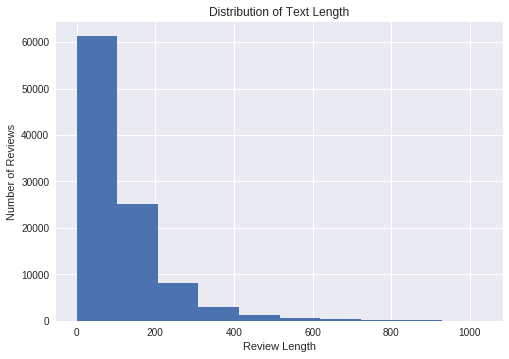

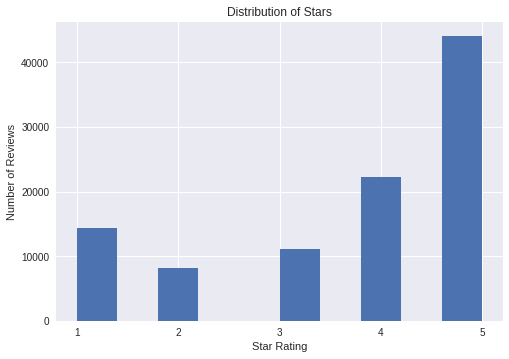

In [7]:
#check length of reviews
plt.hist(length)
plt.title("Distribution of Text Length")
plt.xlabel("Review Length")
plt.ylabel("Number of Reviews")
plt.show()

#check distribution of stars
plt.hist(data['stars'])
plt.xticks(range(1,6))
plt.title("Distribution of Stars")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

In [0]:
X = data['text']
y_1 = data['stars'].values

#encode data w/ keras Tokenizer
t = Tokenizer()
t.fit_on_texts(X)

maxlength = 200
X = encoded_docs = t.texts_to_sequences(X)
X = pad_sequences(X, maxlen=maxlength, padding='post')

In [9]:
def one_hot(star):
    dummy = np.zeros((5,1))
    dummy[star-1,:] = 1
    return dummy
  
y = np.asarray(y_1)
y = y.reshape(-1, 1)

y = np.apply_along_axis(one_hot, 1, y)
y = y.reshape(100000, 5)

print(y)

[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


In [0]:
#split data into train, val, test set
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(
                                    X_train, y_train,
                                    test_size=0.2)

In [11]:
embed_ind = dict()

with open('./glove.twitter.27B.100d.txt', 'r') as f:
    for line in f:
        vals = line.split()
        word = vals[0]
        coefs = np.asarray(vals[1:], dtype='float32')
        embed_ind[word] = coefs

print('Loaded %s word vectors.' % len(embed_ind))   

Loaded 23320 word vectors.


In [0]:
vocab_size = len(t.word_index) + 1

embed_mat = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embed_vec = embed_ind.get(word)
    if embed_vec is not None:
        embed_mat[i] = embed_vec

In [0]:
def build_model(lr=0.0, bi='False'):
    model = Sequential()
    
    model.add(Embedding(vocab_size, 100, weights=[embed_mat], input_length=maxlength, trainable=False))
    
    if bi=='True':
        model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True)))
        model.add(Bidirectional(LSTM(64,  dropout=0.1, recurrent_dropout=0.5,return_sequences=True)))
    else:
        model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
        model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
    
    model.add(GlobalMaxPooling1D())
    
    model.add(Dense(5, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    
    return model

In [20]:
vanilla_model = build_model(1e-4)
print(vanilla_model.summary())
hist = vanilla_model.fit(X_train, y_train, batch_size=1024, epochs=20, validation_data=(X_val, y_val))
loss, accuracy = vanilla_model.evaluate(X_val, y_val)
print('Accuracy: %f' % (accuracy*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 100)          8761800   
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 32)           17024     
_________________________________________________________________
lstm_10 (LSTM)               (None, 200, 64)           24832     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 8,803,981
Trainable params: 42,181
Non-trainable params: 8,761,800
_________________________________________________________________
None
Train on 64000 samples, validate on 16000 samples
Epoch 1/20
64000/64000 [==============================] - 84s 1ms/step -

In [16]:
bi_model = build_model(1e-4, bi='True')
print(bi_model.summary())
bi_hist = bi_model.fit(X_train, y_train, batch_size=1024, epochs=20, validation_data=(X_val, y_val))
loss, accuracy = bi_model.evaluate(X_val, y_val)
print('Accuracy: %f' % (accuracy*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          8761800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 64)           34048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 128)          66048     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 8,862,541
Trainable params: 100,741
Non-trainable params: 8,761,800
_________________________________________________________________
None
Train on 64000 samples, validate on 16000 samples
Epoch 1/20
64000/64000 [==============================] - 168s 3ms/step

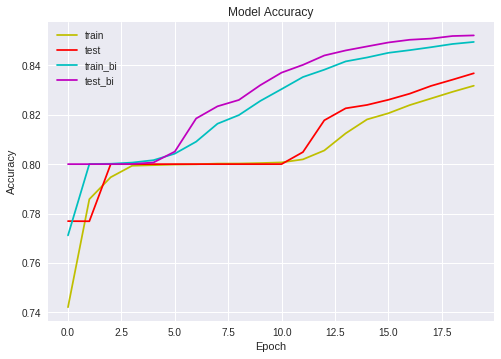

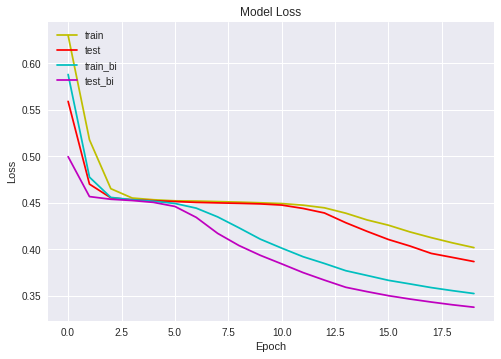

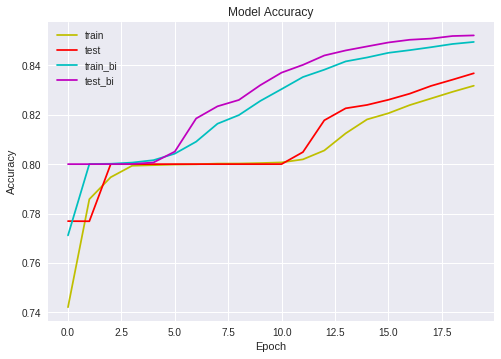

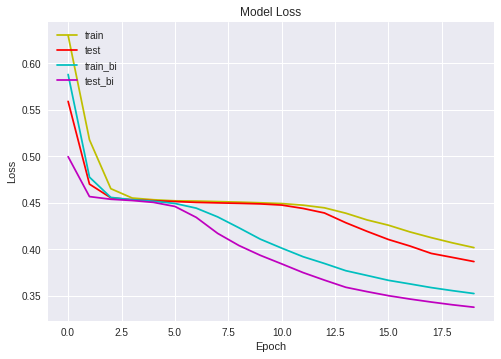

In [22]:
plt.plot(hist.history['acc'], 'y')
plt.plot(hist.history['val_acc'], 'r')
plt.plot(bi_hist.history['acc'], 'c')
plt.plot(bi_hist.history['val_acc'], 'm')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'train_bi', 'test_bi'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'], 'y')
plt.plot(hist.history['val_loss'], 'r')
plt.plot(bi_hist.history['loss'], 'c')
plt.plot(bi_hist.history['val_loss'], 'm')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'train_bi', 'test_bi'], loc='upper left')
plt.show()

In [28]:
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

20000/20000 [==============================] - 275s 14ms/step
Accuracy: 80.00%


In [29]:
bi_scores = bi_model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (bi_scores[1]*100))

20000/20000 [==============================] - 529s 26ms/step
Accuracy: 85.26%
